In [12]:
# Importing necessary libraries

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', False)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("cubehelix") # Other palettes: "Set2", "husl", "cubehelix", "hls"

In [13]:
# Reading the input file

import os
cwd = os.getcwd()

train_values = cwd + "\\Source Data\\train_values.csv"
train_values = pd.read_csv(train_values)
train_labels = cwd + "\\Source Data\\train_labels.csv"
train_labels = pd.read_csv(train_labels)

test_values = cwd + "\\Source Data\\test_values.csv"
test_values = pd.read_csv(test_values)
test_id = test_values.patient_id
test = test_values.drop('patient_id', axis=1)

train = train_values.join(train_labels.set_index('patient_id'), on='patient_id', how='left')

In [14]:
# Data Prep

re_categorize_values = {"chest_pain_type": {1: "one", 2: "two", 3: "three", 4: "four"},
                       "fasting_blood_sugar_gt_120_mg_per_dl": {0: "Less than 120", 1: "Greater than 120"},
                       "resting_ekg_results": {1: "one", 2: "two", 0: "zero"},
                       "sex": {0: "female", 1: "male"},
                       "exercise_induced_angina": {0: "No", 1: "Yes"}}

train.replace(re_categorize_values, inplace=True)
test.replace(re_categorize_values, inplace=True)

y = train['heart_disease_present']
x = train.drop(['heart_disease_present', 'patient_id'], axis=1)

In [15]:
# Fixing Outliers

# Fixing outliers for the resting blood pressure
uplimit = (1.5 * (x.resting_blood_pressure.quantile(0.75) - x.resting_blood_pressure.quantile(0.25))) + x.resting_blood_pressure.quantile(0.75)
lowlimit =  x.resting_blood_pressure.quantile(0.25) - (1.5 * (x.resting_blood_pressure.quantile(0.75) - x.resting_blood_pressure.quantile(0.25)))
median_value = x['resting_blood_pressure'].median()

x['resting_blood_pressure'] = np.where((x.resting_blood_pressure > uplimit) | (x.resting_blood_pressure < lowlimit), median_value, x.resting_blood_pressure)
test['resting_blood_pressure'] = np.where((test.resting_blood_pressure > uplimit) | (test.resting_blood_pressure < lowlimit), median_value, test.resting_blood_pressure)


# Fixing serum cholesterol mg per dl
uplimit = (1.5 * (x.serum_cholesterol_mg_per_dl.quantile(0.75) - x.serum_cholesterol_mg_per_dl.quantile(0.25))) + x.serum_cholesterol_mg_per_dl.quantile(0.75)
lowlimit =  x.serum_cholesterol_mg_per_dl.quantile(0.25) - (1.5 * (x.serum_cholesterol_mg_per_dl.quantile(0.75) - x.serum_cholesterol_mg_per_dl.quantile(0.25)))
median_value = x['serum_cholesterol_mg_per_dl'].median()

x['serum_cholesterol_mg_per_dl'] = np.where((x.serum_cholesterol_mg_per_dl > uplimit) | (x.serum_cholesterol_mg_per_dl < lowlimit), median_value, x.serum_cholesterol_mg_per_dl)
test['serum_cholesterol_mg_per_dl'] = np.where((test.serum_cholesterol_mg_per_dl > uplimit) | (test.serum_cholesterol_mg_per_dl < lowlimit), median_value, test.serum_cholesterol_mg_per_dl)

# Fixing old peak eq st depression
uplimit = (1.5 * (x.oldpeak_eq_st_depression.quantile(0.75) - x.oldpeak_eq_st_depression.quantile(0.25))) + x.oldpeak_eq_st_depression.quantile(0.75)
lowlimit =  x.oldpeak_eq_st_depression.quantile(0.25) - (1.5 * (x.oldpeak_eq_st_depression.quantile(0.75) - x.oldpeak_eq_st_depression.quantile(0.25)))
median_value = x['oldpeak_eq_st_depression'].median()

x['oldpeak_eq_st_depression'] = np.where((x.oldpeak_eq_st_depression > uplimit) | (x.oldpeak_eq_st_depression < lowlimit), median_value, x.oldpeak_eq_st_depression)
test['oldpeak_eq_st_depression'] = np.where((test.oldpeak_eq_st_depression > uplimit) | (test.oldpeak_eq_st_depression < lowlimit), median_value, test.oldpeak_eq_st_depression)


# Feature Engineering

In [16]:
x['heart_risk'] = np.where(x.sex == 'male',0.25,0) + np.where(x.chest_pain_type == 'four',0.5,0) + np.where(x.exercise_induced_angina == 'Yes',0.5,0) + np.where(x.thal == 'reversible_defect',0.5,0) + np.where(x.slope_of_peak_exercise_st_segment >= 2,1,0) + np.where(x.num_major_vessels > 0, 1,0) + np.where(x.oldpeak_eq_st_depression > 0, 1,0) + np.where((x.age > 50) & (x.age < 70),0.5,0) + np.where(x.max_heart_rate_achieved < 140 , 1,0) 
test['heart_risk'] = np.where(test.sex == 'male',0.25,0) + np.where(test.chest_pain_type == 'four',0.5,0) + np.where(test.exercise_induced_angina == 'Yes',0.5,0) + np.where(test.thal == 'reversible_defect',0.5,0) + np.where(test.slope_of_peak_exercise_st_segment >= 2,1,0) + np.where(test.num_major_vessels > 0, 1,0) + np.where(test.oldpeak_eq_st_depression > 0, 1,0) + np.where((test.age > 50) & (test.age < 70),0.5,0) + np.where(test.max_heart_rate_achieved < 140 , 1,0) 


# exercise induced angina = Yes, and slope of peak = 3 is always heart disease present (6 obs)
x['angina_and_slope_of_peak'] = np.where((x.exercise_induced_angina =='Yes') & 
                                         (x.slope_of_peak_exercise_st_segment==3),1,0)

test['angina_and_slope_of_peak'] = np.where((test.exercise_induced_angina =='Yes') & 
                                         (test.slope_of_peak_exercise_st_segment==3),1,0)

# exercise induced angina = Yes, chest pain type = four, and num major vessels = 2, heart dis always present (0 obs)
x['angina_chestPain_numVessels'] = np.where((x.exercise_induced_angina =='Yes') & (x.chest_pain_type == 'four') &
                                         (x.num_major_vessels==2),1,0)

test['angina_chestPain_numVessels'] = np.where((test.exercise_induced_angina =='Yes') & (test.chest_pain_type == 'four') &
                                         (test.num_major_vessels==2),1,0)

# exercise induced angina = Yes, and num major vessels = 3, heart dis always present (0 obs)
x['angina_numVessels'] = np.where((x.exercise_induced_angina =='Yes') &
                                         (x.num_major_vessels==3),1,0)

test['angina_numVessels'] = np.where((test.exercise_induced_angina =='Yes') &
                                         (test.num_major_vessels==3),1,0)

# sex = female, and num major vessels = 3, heart dis always present (3 obs)
x['sex_numVessels'] = np.where((x.sex =='female') & (x.num_major_vessels==3),1,0)
test['sex_numVessels'] = np.where((test.sex =='female') &(test.num_major_vessels==3),1,0)

# max HR achieved < 146, and num major vessels = 3, heart dis always present (10 obs)
x['maxHR_numVessels'] = np.where((x.max_heart_rate_achieved < 146) & (x.num_major_vessels==3),1,0)
test['maxHR_numVessels'] = np.where((test.max_heart_rate_achieved < 146) &(test.num_major_vessels==3),1,0)

# thal=normal, and num major vessels in 0&1, chest pain type =2, heart dis never present (19 obs)
x['thal_numVessels_chestPain'] = np.where((x.thal=='normal') & (x.num_major_vessels.isin([0,1])) &
                                          (x.chest_pain_type=='two') ,1,0)
test['thal_numVessels_chestPain'] = np.where((test.thal=='normal') & (test.num_major_vessels.isin([0,1])) &
                                          (test.chest_pain_type=='two') ,1,0)

# thal=reversible_defect, and slope of peak.. =2 , chest pain type =4, and max HR > 105 heart dis always present (25 obs)
x['thal_slope_chestPain_maxHR'] = np.where((x.thal=='reversible_defect') & (x.max_heart_rate_achieved > 105 ) &
                                          (x.chest_pain_type=='four') & (x.slope_of_peak_exercise_st_segment==2) ,1,0)
test['thal_slope_chestPain_maxHR'] = np.where((test.thal=='reversible_defect') & (test.max_heart_rate_achieved > 105) &
                                          (test.chest_pain_type=='four') & (test.slope_of_peak_exercise_st_segment==2) ,1,0)

# resting ekg = two, thal = reversible defect, and num major vessels in 1 & 3 heart dis always present (12 obs)
x['restEkg_thal_numVessels'] = np.where((x.thal=='reversible_defect') & (x.resting_ekg_results=='two' ) &
                                          (x.num_major_vessels.isin([1,3])),1,0)
test['restEkg_thal_numVessels'] = np.where((test.thal=='reversible_defect') & (test.resting_ekg_results=='two' ) &
                                          (test.num_major_vessels.isin([1,3])),1,0)

# slope of peak = 1, sex=female, chest pain = four and num major vessels in 1 & 0 heart dis never present (21 obs)
x['slope_sex_chestPain_numVessels'] = np.where((x.slope_of_peak_exercise_st_segment==1) &
                                        (x.sex=='female' ) & (x.num_major_vessels.isin([1,0])) &
                                        (x.chest_pain_type=='four'),1,0)

test['slope_sex_chestPain_numVessels'] = np.where((test.slope_of_peak_exercise_st_segment==1) &
                                        (test.sex=='female' ) & (test.num_major_vessels.isin([1,0])) &
                                        (test.chest_pain_type=='four'),1,0)

# major vessels in 2 & 3, exercise induced =1, and chest pain = four heart dis always present (15 obs)
x['numVessels_angina_chestPain'] = np.where((x.num_major_vessels.isin([2,3])) &
                                        (x.exercise_induced_angina=='Yes') & (x.chest_pain_type=='four'),1,0)

test['numVessels_angina_chestPain'] = np.where((test.num_major_vessels.isin([2,3])) &
                                        (test.exercise_induced_angina=='Yes') & (test.chest_pain_type=='four'),1,0)

In [17]:
# Generating dummies

x_rows = x.shape[0]
df = x.append(test)

df = pd.get_dummies(df, drop_first=True)

x = df.iloc[:x_rows,]
test = df.iloc[x_rows:,]

In [6]:
# # STANDARDIZING FEATURES USING STANDARD SCALER
# from sklearn.preprocessing import StandardScaler

# stdScaler = StandardScaler()
# colNames = x.columns

# x = stdScaler.fit_transform(x)
# x = pd.DataFrame(data=x, columns=colNames)

# test = stdScaler.fit_transform(test)
# test = pd.DataFrame(data=test, columns=colNames)

In [7]:
# # NORMALIZING FEATURES USING NORMALIZER SCALER
# from sklearn.preprocessing import Normalizer

# scaler = Normalizer()
# colNames = x.columns

# x = scaler.fit_transform(x)
# x = pd.DataFrame(data=x, columns=colNames)

# test = scaler.fit_transform(test)
# test = pd.DataFrame(data=test, columns=colNames)

In [18]:
# Standardizing data using Power Transformer
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method='yeo-johnson', standardize=True)

colNames = x.columns
x = scaler.fit_transform(x)
x = pd.DataFrame(data=x, columns=colNames)

test = scaler.fit_transform(test)
test = pd.DataFrame(data=test, columns=colNames)

In [9]:
# # Standardizing data using Quantile Transformer
# from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer(output_distribution='normal')

# colNames = x.columns
# x = scaler.fit_transform(x)
# x = pd.DataFrame(data=x, columns=colNames)

# test = scaler.fit_transform(test)
# test = pd.DataFrame(data=test, columns=colNames)

In [10]:
# # Standardizing data using MinMax Scaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0,1))

# colNames = x.columns
# x = scaler.fit_transform(x)
# x = pd.DataFrame(data=x, columns=colNames)

# test = scaler.fit_transform(test)
# test = pd.DataFrame(data=test, columns=colNames)

In [11]:
# # PCA Analysis to define the number of components

# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA()
# model = pca.fit(x)

# plt.plot(np.cumsum(model.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

There does not seem to be any noticable benefit from using PCA. But, let us still go ahead and run PCA for 12 components

In [12]:
# pca = PCA(n_components=12)
# x = pca.fit_transform(x)

# x = pd.DataFrame(data=x, columns=colNames)

# test = pca.fit_transform(test)
# test = pd.DataFrame(data=test, columns=colNames)

# Random Search Optimizer for SVC

In [13]:
# Creating a Random Grid

from sklearn.model_selection import RandomizedSearchCV

# Setting parameters for SVC
kernel = ['linear', 'poly', 'rbf']
C = [0.5, 1, 10, 20, 50]
gamma = [1, 5, 30, 50, 100]
decision_function_shape = ['ovo', 'ovr']


# Create the random grid
random_grid = {'kernel': kernel,
               'C': C,
               'decision_function_shape': decision_function_shape,
               'gamma':gamma}

random_grid

{'kernel': ['linear', 'poly', 'rbf'],
 'C': [0.5, 1, 10, 20, 50],
 'decision_function_shape': ['ovo', 'ovr'],
 'gamma': [1, 5, 30, 50, 100]}

In [14]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [15]:
# Performing the Random Search

# Use the random grid to search for best hyperparameters
# Let us use the base model "model" that is already created to tune the model against
from sklearn.svm import SVC
model = SVC(probability=True, random_state=1)

scoring = ['neg_log_loss', 'precision', 'recall']
# Multiple scoring cannot be used in RandomSearch unless refit is set to False. However, if refit is 
# set to false, then we cannot retrieve the best params and best estimators

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator = model, 
                                  param_distributions = random_grid, refit=True, n_jobs = -1,
                                  n_iter = 150, cv = 3, scoring='neg_log_loss', 
                                  verbose=200, random_state=42)
# Fit the random search model
model_random.fit(x, y)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(119,), dtype=int32).
Pickling array (shape=(61,), dtype=int32).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(120,), dtype=int32).
Pickling array (shape=(60,), dtype=int32).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(121,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(17,), dtype=object).
Pickling arra

Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(121,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(119,), dtype=int32).
Pickling array (shape=(61,), dtype=int32).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    4.0s

Pickling array (shape=(120,), dtype=int32).
Pickling array (shape=(60,), dtype=int32).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object

Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(120,), dtype=int32).
Pickling array (shape=(60,), dtype=int32).
Pickling array (shape=(121,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(119,), dtype=int32).
Pickling array (shape=(61,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    4.4s
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1848s.) Setting batch_size=8.
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(121,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pic

[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:    5.0s
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(121,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(119,), dtype=int32).
Pickling array (shape=(61,), dtype=int32).
Pickling array (shape=(120,), dtype=int32).
Pickling array (shape=(60,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    5.0s
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(120,), dtype=int32).
Pickling array (shape=(60,), dtype=int32).
Pickling array (shape=(121,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(119,), dtype=int32).
Pickling array (shape=(61,), dtype=

[Parallel(n_jobs=-1)]: Done 331 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 339 out of 450 | elapsed:    6.3s remaining:    2.0s
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(120,), dtype=int32).
Pickling array (shape=(60,), dtype=int32).
Pickling array (shape=(121,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(119,), dtype=int32).
Pickling array (shape=(61,), dtype=int32).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(17, 180), dtype=float64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(180,), dtype=int64).
Pickling array (shape=(119,), dtype=int32).
Pickling array (shape=(61,), dtype=int32).
Pickling array (shape=(120,), dtype=int32).
Pickling array (shape=(60,), dtype=int32).
Pickling array (shape=(121,), dtype=int32).
Pickling array (

C:\Users\sivac\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=150, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'poly', 'rbf'], 'C': [0.5, 1, 10, 20, 50], 'decision_function_shape': ['ovo', 'ovr'], 'gamma': [1, 5, 30, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=200)

In [16]:
print(model_random.best_estimator_)
print(model_random.best_score_)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False)
-0.42510314660921317


In [17]:
# Best estimator using SVC and Standard Scaler
# SVC(C=0.5, cache_size=500, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=100, kernel='linear',
#  max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)

#Alternate Model 2

# SVC(C=1, cache_size=500, class_weight=None, coef0=0.0, decision_function_shape='ovo', degree=3, gamma=1, kernel='linear',
#  max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)


# Alternate Model 3

# SVC(C=0.5, cache_size=500, class_weight=None, coef0=0.0, decision_function_shape='ovo', degree=3, gamma=30, kernel='linear',
#  max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)

# Alternate Model 4

# SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovo', degree=3, gamma=1, kernel='linear',
#  max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)

In [19]:
# Performing the Train Test Split

from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x,y, 
                                                                stratify=y, 
                                                                random_state=1, 
                                                                test_size=0.25)

Confustion Matrix for Training Data - SVC
[[71  4]
 [11 49]]
Confustion Matrix for Test Data - SVC
[[21  4]
 [ 5 15]]
Classification Report for Training Data - SVC
              precision    recall  f1-score   support

           0       0.87      0.95      0.90        75
           1       0.92      0.82      0.87        60

   micro avg       0.89      0.89      0.89       135
   macro avg       0.90      0.88      0.89       135
weighted avg       0.89      0.89      0.89       135

Classification Report for Test Data - SVC
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        25
           1       0.79      0.75      0.77        20

   micro avg       0.80      0.80      0.80        45
   macro avg       0.80      0.79      0.80        45
weighted avg       0.80      0.80      0.80        45

Log loss for Training data:  0.3171377413424788
Log loss for Validation data:  0.4216404494517555

AUROC Plot from SVC: 0.8720


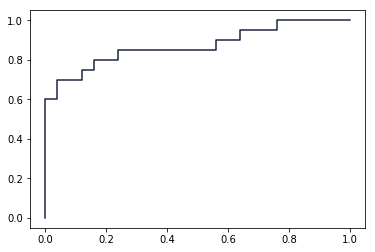

In [20]:
# Running the Random Forest Classifier using the best estimator

# model = model_random.best_estimator_
# Choosing the best model
from sklearn.svm import SVC
model = SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovo', degree=3, gamma=1, kernel='linear', 
            max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001, verbose=False)

model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

# Accuracy Metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data - SVC")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data - SVC")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data - SVC")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data - SVC")
print(classification_report(y_validation, predictions))

proba_train_predictions = model.predict_proba(x_train)[:,1]
proba_predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, proba_predictions, average='weighted')

# Print the log loss metric

print("Log loss for Training data: ", log_loss(y_train, proba_train_predictions))
print("Log loss for Validation data: ", log_loss(y_validation, proba_predictions))

fpr, tpr, threshold = roc_curve(y_validation, proba_predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("\nAUROC Plot from SVC:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

Power Transformer data performs little better than Std Scaler, Normalization

In [21]:
# Generating output using Logistic Regression without normalizing the data

proba_test_predictions = model.predict_proba(test)[:,1]

output = pd.DataFrame({'patient_id': test_id, 'heart_disease_present':proba_test_predictions})
output.to_csv(cwd + "\\Output Data\\Submission 19 - SVC-reshaped_data-PowerTransformer-FeatureEngineering logloss 0.4216.csv", index=False)

In [21]:
# # Pushing the repo to git

# ! cd "C:\\Users\\sivac\\Documents\\Python Projects\\Driven Data\\Predicting Heart Disease"

# ! git add .
# ! git commit -am "Submission 17 - SVC-PowerTransformed Data with RandomSearch 0.3770"
# ! git push